## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix

# Sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from nltk import sent_tokenize
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# For progress bars
from tqdm.auto import tqdm
tqdm.pandas()

C:\Users\bakir\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [3]:
# load transport-related data
df = pd.read_csv("data/csv/transport_final.csv")
df['text'] = df['text'].fillna('').astype(str)

print(f"Total transport documents: {len(df)}")
df.head()

Total transport documents: 417


,Unnamed: 0,date,topic,text,term,clean_text,bertopic_topic,bertopic_prob,is_bertopic,lda_topic,...,is_nmf,top2vec_topic,top2vec_score,is_top2vec,is_full,is_shortened,keywords_full,keywords_shortened,num_approaches_agree,is_transport
0,63,15-04-1999,4. Transport infrastructure charging,President . – The next item is the report (A4‐...,94_99,schmidbauer transport tourism white paper enti...,64,1.000000,True,19,...,True,15,0.826061,True,True,False,"['bus', 'car', 'infrastructure', 'rail', 'road...",[],4,True
1,65,15-04-1999,6. Transport infrastructure charging (continua...,President . – The next item is the continuatio...,94_99,continuation schmidbauer transport tourism whi...,64,0.914965,True,19,...,True,15,0.789501,True,True,False,"['air transport', 'airport', 'car', 'infrastru...",[],4,True
2,66,15-04-1999,7. Maximum authorised dimensions and weights i...,President . – The next item is the second repo...,94_99,van dam transport tourism directive amending d...,-1,0.000000,False,19,...,True,15,0.782774,True,True,False,"['bus', 'car', 'freight transport', 'rail', 'r...",[],3,True
3,134,10-03-1999,6. VOTES,"Report (A4‐0063/99) by Mrs Hardstaff, on behal...",94_99,hardstaff fisheries communication implementati...,11,0.833863,False,19,...,True,16,0.835329,False,True,True,"['air transport', 'airport', 'boat', 'bus', 'c...","['air transport', 'freight transport', 'passen...",3,True
4,156,09-03-1999,14. Transportable pressure equipment,President . – The next item is the recommendat...,94_99,recommendation transport tourism common positi...,36,0.658336,True,65,...,True,15,0.867278,True,False,False,[],[],3,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            417 non-null    int64  
 1   date                  417 non-null    object 
 2   topic                 417 non-null    object 
 3   text                  417 non-null    object 
 4   term                  417 non-null    object 
 5   clean_text            417 non-null    object 
 6   bertopic_topic        417 non-null    int64  
 7   bertopic_prob         417 non-null    float64
 8   is_bertopic           417 non-null    bool   
 9   lda_topic             417 non-null    int64  
 10  lda_prob              417 non-null    float64
 11  is_lda                417 non-null    bool   
 12  nmf_topic             417 non-null    int64  
 13  nmf_prob              417 non-null    float64
 14  is_nmf                417 non-null    bool   
 15  top2vec_topic         4

## SIA (VADER) Approach

In [5]:
# Initialize analyzer
analyzer = SIA()

In [6]:
# get scores
scores = df['text'].apply(analyzer.polarity_scores)
df['sia_compound'] = scores.apply(lambda s: s['compound'])
df['sia_negative'] = scores.apply(lambda s: s['neg'])
df['sia_neutral'] = scores.apply(lambda s: s['neu'])
df['sia_positive'] = scores.apply(lambda s: s['pos'])

# classify sentiment
df['sentiment_sia'] = 'neutral'
df.loc[df['sia_compound'] > 0.05, 'sentiment_sia'] = 'positive'
df.loc[df['sia_compound'] < -0.05, 'sentiment_sia'] = 'negative'

In [7]:
print("=== SIA Sentiment Distribution ===")
print(df['sentiment_sia'].value_counts(normalize=True))

=== SIA Sentiment Distribution ===
sentiment_sia
positive    0.988010
negative    0.009592
neutral     0.002398
Name: proportion, dtype: float64


In [8]:
print(df['sentiment_sia'].value_counts().get('neutral', 0))
print(df['sentiment_sia'].value_counts().get('positive', 0))
print(df['sentiment_sia'].value_counts().get('negative', 0))

1
412
4


In [10]:
print(df['sia_compound'].describe())
print(df['sia_compound'].value_counts().head(10))

count    417.000000
mean       0.974179
std        0.189356
min       -0.995200
25%        0.999900
50%        1.000000
75%        1.000000
max        1.000000
Name: sia_compound, dtype: float64
sia_compound
1.0000    226
0.9999     88
0.9998     26
0.9996      8
0.9992      5
0.9997      5
0.9995      4
0.9993      4
0.9994      3
0.9987      2
Name: count, dtype: int64


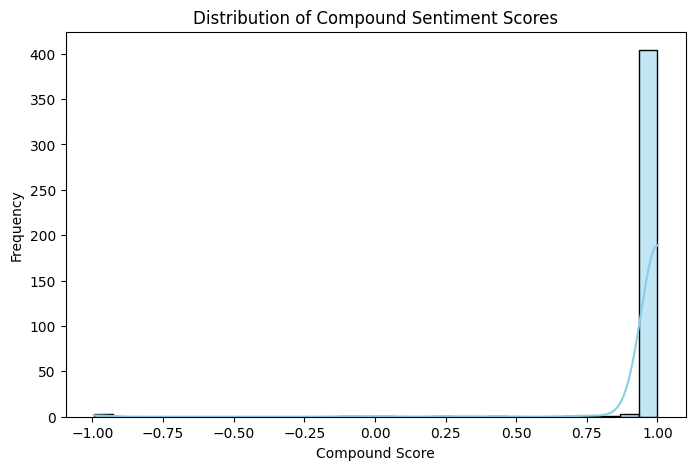

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['sia_compound'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

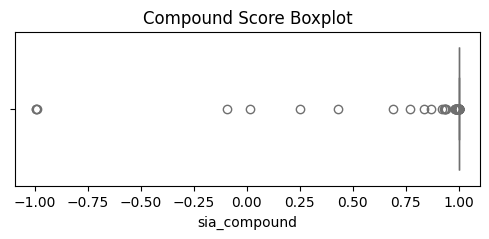

In [12]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['sia_compound'], color='skyblue')
plt.title('Compound Score Boxplot')
plt.show()

## Sentence-Level Approach

In [13]:
def score_text_sentence_level(text):
    """Score text at sentence-level and aggregate with length weighting."""
    if not isinstance(text, str) or not text.strip():
        return {'compound_mean': 0, 'compound_len_weighted': 0, 
                'pos_mean': 0, 'neu_mean': 0, 'neg_mean': 0, 'n_sent': 0}
    
    sents = sent_tokenize(text)
    scores = [analyzer.polarity_scores(s) for s in sents if s.strip()]
    
    if not scores:
        return {'compound_mean': 0, 'compound_len_weighted': 0,
                'pos_mean': 0, 'neu_mean': 0, 'neg_mean': 0, 'n_sent': 0}
    
    # simple mean
    comp = np.array([s['compound'] for s in scores])
    pos = np.array([s['pos'] for s in scores])
    neu = np.array([s['neu'] for s in scores])
    neg = np.array([s['neg'] for s in scores])
    
    # length-weighted mean
    weights = np.array([len(s.split()) for s in sents if s.strip()])
    w = weights / weights.sum() if weights.sum() > 0 else 1.0
    
    return {
        'compound_mean': float(np.mean(comp)),
        'compound_len_weighted': float(np.average(comp, weights=w)),
        'pos_mean': float(np.mean(pos)),
        'neu_mean': float(np.mean(neu)),
        'neg_mean': float(np.mean(neg)),
        'n_sent': len(scores)
    }

In [14]:
# apply the sentence-level scoring
agg_df = df['text'].progress_apply(score_text_sentence_level)
agg_df = pd.DataFrame(list(agg_df))
df = pd.concat([df, agg_df], axis=1)

100%|██████████| 417/417 [00:30<00:00, 13.61it/s]


In [15]:
# make classification using length-weighted compound
NEUTRAL_BAND = 0.10
df['sentiment_sentence'] = 'neutral'
df.loc[df['compound_len_weighted'] > NEUTRAL_BAND, 'sentiment_sentence'] = 'positive'
df.loc[df['compound_len_weighted'] < -NEUTRAL_BAND, 'sentiment_sentence'] = 'negative'

In [16]:
print("\n=== Sentence-Level Sentiment Distribution ===")
print(df['sentiment_sentence'].value_counts(normalize=True))


=== Sentence-Level Sentiment Distribution ===
sentiment_sentence
positive    0.942446
neutral     0.057554
Name: proportion, dtype: float64


In [17]:
sentiment_sentence_counts = df['sentiment_sentence'].value_counts()
print(sentiment_sentence_counts)

sentiment_sentence
positive    393
neutral      24
Name: count, dtype: int64


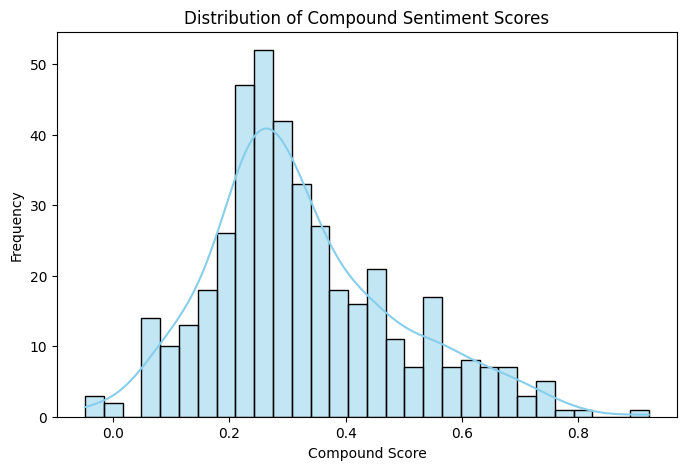

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df['compound_len_weighted'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

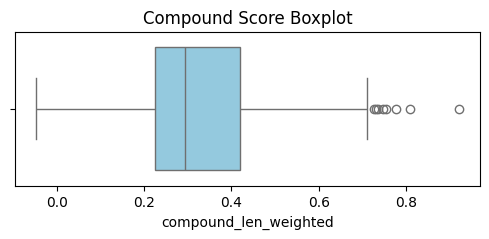

In [21]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['compound_len_weighted'], color='skyblue')
plt.title('Compound Score Boxplot')
plt.show()

In [22]:
print(f"\nAverage sentences per document: {df['n_sent'].mean():.1f}")
print(f"Median sentences per document: {df['n_sent'].median():.1f}")


Average sentences per document: 261.8
Median sentences per document: 203.0


## Transformer-Based Approach

In [24]:
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

device = 0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
clf = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device, return_all_scores=True)

Device set to use cuda:0
C:\Users\bakir\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [27]:
# Map HF labels to indices
label_to_id = {label: idx for idx, label in clf.model.config.id2label.items()}

In [28]:
def score_sentences(sentences, batch_size=32, max_len=256):
    """Score sentences in batches."""
    if not sentences:
        return []
    out = clf(sentences, batch_size=batch_size, truncation=True, max_length=max_len)
    neg = np.array([d[label_to_id['negative']]['score'] for d in out], dtype=float)
    neu = np.array([d[label_to_id['neutral']]['score'] for d in out], dtype=float)
    pos = np.array([d[label_to_id['positive']]['score'] for d in out], dtype=float)
    return neg, neu, pos

In [29]:
def sentence_level_agg(text):
    """Sentence-level transformer sentiment with length-weighted aggregation."""
    if not isinstance(text, str) or not text.strip():
        return {'xlmr_compound_mean': 0, 'xlmr_compound_len_weighted': 0,
                'xlmr_pos_mean': 0, 'xlmr_neu_mean': 0, 'xlmr_neg_mean': 0, 'xlmr_n_sent': 0}
    
    sents = [s.strip() for s in sent_tokenize(text) if s.strip()]
    neg, neu, pos = score_sentences(sents)
    
    # "compound" proxy: pos - neg (centered in [-1,1] approximately)
    comp = pos - neg
    
    # again length-weighted mean
    weights = np.array([len(s.split()) for s in sents])
    w = weights / weights.sum() if weights.sum() > 0 else 1.0
    
    return {
        'xlmr_compound_mean': float(np.mean(comp)),
        'xlmr_compound_len_weighted': float(np.average(comp, weights=w)),
        'xlmr_pos_mean': float(np.mean(pos)),
        'xlmr_neu_mean': float(np.mean(neu)),
        'xlmr_neg_mean': float(np.mean(neg)),
        'xlmr_n_sent': len(sents)
    }

In [30]:
# transformer scoring
agg_df = df['text'].progress_apply(sentence_level_agg)
agg_df = pd.DataFrame(list(agg_df))
df = pd.concat([df, agg_df], axis=1)

# Classify using length-weighted compound
NEUTRAL_BAND = 0.10
df['sentiment_transformer'] = 'neutral'
df.loc[df['xlmr_compound_len_weighted'] > NEUTRAL_BAND, 'sentiment_transformer'] = 'positive'
df.loc[df['xlmr_compound_len_weighted'] < -NEUTRAL_BAND, 'sentiment_transformer'] = 'negative'


  0%|          | 0/417 [00:00<?, ?it/s]C:\Users\bakir\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 417/417 [09:45<00:00,  1.40s/it]


In [31]:
print("\n=== Transformer Sentiment Distribution ===")
print(df['sentiment_transformer'].value_counts(normalize=True))


=== Transformer Sentiment Distribution ===
sentiment_transformer
neutral     0.580336
positive    0.232614
negative    0.187050
Name: proportion, dtype: float64


In [32]:
print(df['sentiment_transformer'].value_counts())

sentiment_transformer
neutral     242
positive     97
negative     78
Name: count, dtype: int64


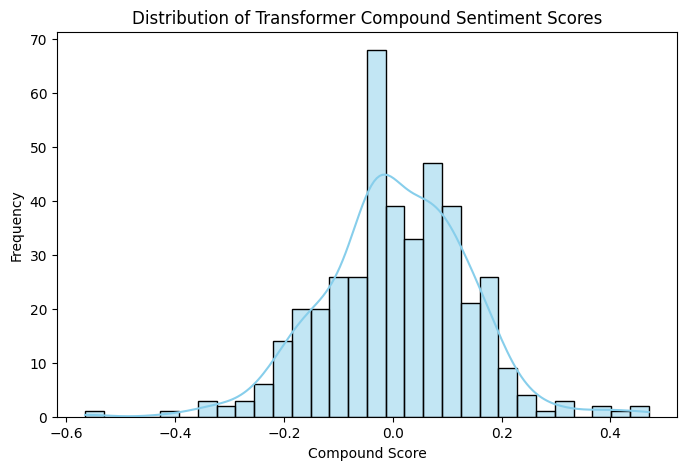

In [33]:
plt.figure(figsize=(8, 5))
sns.histplot(df['xlmr_compound_len_weighted'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Transformer Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

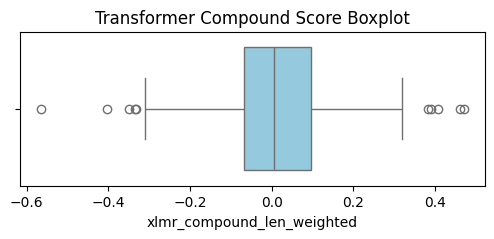

In [34]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['xlmr_compound_len_weighted'], color='skyblue')
plt.title('Transformer Compound Score Boxplot')
plt.show()

In [35]:
df.head()

,Unnamed: 0,date,topic,text,term,clean_text,bertopic_topic,bertopic_prob,is_bertopic,lda_topic,...,neg_mean,n_sent,sentiment_sentence,xlmr_compound_mean,xlmr_compound_len_weighted,xlmr_pos_mean,xlmr_neu_mean,xlmr_neg_mean,xlmr_n_sent,sentiment_transformer
0,63,15-04-1999,4. Transport infrastructure charging,President . – The next item is the report (A4‐...,94_99,schmidbauer transport tourism white paper enti...,64,1.000000,True,19,...,0.054963,108,positive,-0.110263,-0.099388,0.244694,0.400348,0.354957,108,neutral
1,65,15-04-1999,6. Transport infrastructure charging (continua...,President . – The next item is the continuatio...,94_99,continuation schmidbauer transport tourism whi...,64,0.914965,True,19,...,0.053611,113,positive,-0.044003,-0.032266,0.258989,0.438018,0.302993,113,neutral
2,66,15-04-1999,7. Maximum authorised dimensions and weights i...,President . – The next item is the second repo...,94_99,van dam transport tourism directive amending d...,-1,0.000000,False,19,...,0.046456,90,positive,-0.177908,-0.164551,0.198177,0.425737,0.376086,90,negative
3,134,10-03-1999,6. VOTES,"Report (A4‐0063/99) by Mrs Hardstaff, on behal...",94_99,hardstaff fisheries communication implementati...,11,0.833863,False,19,...,0.039270,477,positive,-0.099796,-0.117570,0.224623,0.450958,0.324419,477,negative
4,156,09-03-1999,14. Transportable pressure equipment,President . – The next item is the recommendat...,94_99,recommendation transport tourism common positi...,36,0.658336,True,65,...,0.030754,65,positive,0.113471,0.138031,0.330405,0.452662,0.216934,65,positive


### Comparison of Approaches

In [37]:
summary_data = {
    'Method': ['SIA (VADER)', 'Sentence-Level', 'Transformer'],
    'Positive (%)': [
        (df['sentiment_sia'] == 'positive').sum() / len(df) * 100,
        (df['sentiment_sentence'] == 'positive').sum() / len(df) * 100,
        (df['sentiment_transformer'] == 'positive').sum() / len(df) * 100
    ],
    'Neutral (%)': [
        (df['sentiment_sia'] == 'neutral').sum() / len(df) * 100,
        (df['sentiment_sentence'] == 'neutral').sum() / len(df) * 100,
        (df['sentiment_transformer'] == 'neutral').sum() / len(df) * 100
    ],
    'Negative (%)': [
        (df['sentiment_sia'] == 'negative').sum() / len(df) * 100,
        (df['sentiment_sentence'] == 'negative').sum() / len(df) * 100,
        (df['sentiment_transformer'] == 'negative').sum() / len(df) * 100
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== Sentiment Distribution Comparison ===")
print(summary_df.to_string(index=False))


=== Sentiment Distribution Comparison ===
        Method  Positive (%)  Neutral (%)  Negative (%)
   SIA (VADER)     98.800959     0.239808      0.959233
Sentence-Level     94.244604     5.755396      0.000000
   Transformer     23.261391    58.033573     18.705036



=== Distribution Comparison ===

Sentence-Level:
sentiment_sentence
positive    0.942
neutral     0.058
Name: proportion, dtype: float64

Transformer:
sentiment_transformer
neutral     0.580
positive    0.233
negative    0.187
Name: proportion, dtype: float64


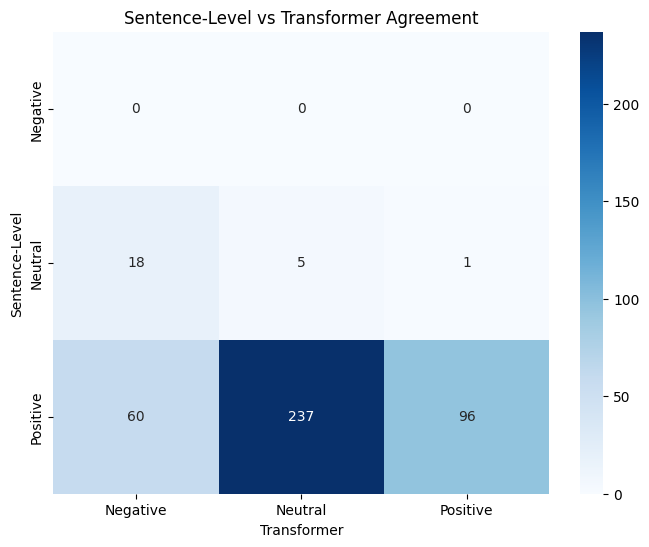


Agreement between Sentence-Level and Transformer: 101/417 (24.2%)


In [36]:
print("\n=== Distribution Comparison ===")
print("\nSentence-Level:")
print(df['sentiment_sentence'].value_counts(normalize=True).round(3))
print("\nTransformer:")
print(df['sentiment_transformer'].value_counts(normalize=True).round(3))

# agreement between the two better methods
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['sentiment_sentence'], df['sentiment_transformer'], 
                     labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Sentence-Level vs Transformer Agreement')
plt.xlabel('Transformer')
plt.ylabel('Sentence-Level')
plt.show()

# calculate agreement
agreement = (df['sentiment_sentence'] == df['sentiment_transformer']).sum()
print(f"\nAgreement between Sentence-Level and Transformer: {agreement}/{len(df)} ({agreement/len(df)*100:.1f}%)")

Based on the given result, the first approach, SIA (VADER) applied to entire text, not at sentence level, was excluded from consideration immediately due to its heavily skewed distribution toward positive sentiment, which does not accurately represent the nature of parliamentary transport-related discussions. 

The final comparison was performed between Sentence-Level VADER and Transformer-based approaches. Since the agreement between the two was only 24.2%, it made the most sense to just stick with one method's results as the final sentiments. The chosen approach was the Transformer-based approach (XLM-RoBERTa), as it identifies more neutral content (58% neutral compared to just 5.8% for the Sentence-Level VADER), captures semantic meaning, going beyond lexicon-based scoring, and in the end represents the current best practices in sentiment analysis.

## Final Classification

In [38]:
# using Transformer as final sentiment
df['sentiment'] = df['sentiment_transformer']
df['sentiment_score'] = df['xlmr_compound_len_weighted']

print("\n=== Final Sentiment Distribution ===")
print(df['sentiment'].value_counts())
print(df['sentiment'].value_counts(normalize=True))


=== Final Sentiment Distribution ===
sentiment
neutral     242
positive     97
negative     78
Name: count, dtype: int64
sentiment
neutral     0.580336
positive    0.232614
negative    0.187050
Name: proportion, dtype: float64


In [39]:
columns_to_keep = [
    'date', 'topic', 'text', 'term', 'clean_text',
    'bertopic_topic', 'bertopic_prob', 'is_bertopic',
    'lda_topic', 'lda_prob', 'is_lda',
    'nmf_topic', 'nmf_prob', 'is_nmf',
    'top2vec_topic', 'top2vec_score', 'is_top2vec',
    'is_full', 'is_shortened',
    'keywords_full', 'keywords_shortened',
    'num_approaches_agree', 'is_transport',
    'sentiment', 'sentiment_score'
]

In [40]:
df_final = df[columns_to_keep]

In [41]:
df_final.head()

,date,topic,text,term,clean_text,bertopic_topic,bertopic_prob,is_bertopic,lda_topic,lda_prob,...,top2vec_score,is_top2vec,is_full,is_shortened,keywords_full,keywords_shortened,num_approaches_agree,is_transport,sentiment,sentiment_score
0,15-04-1999,4. Transport infrastructure charging,President . – The next item is the report (A4‐...,94_99,schmidbauer transport tourism white paper enti...,64,1.000000,True,19,0.388259,...,0.826061,True,True,False,"['bus', 'car', 'infrastructure', 'rail', 'road...",[],4,True,neutral,-0.099388
1,15-04-1999,6. Transport infrastructure charging (continua...,President . – The next item is the continuatio...,94_99,continuation schmidbauer transport tourism whi...,64,0.914965,True,19,0.485889,...,0.789501,True,True,False,"['air transport', 'airport', 'car', 'infrastru...",[],4,True,neutral,-0.032266
2,15-04-1999,7. Maximum authorised dimensions and weights i...,President . – The next item is the second repo...,94_99,van dam transport tourism directive amending d...,-1,0.000000,False,19,0.487040,...,0.782774,True,True,False,"['bus', 'car', 'freight transport', 'rail', 'r...",[],3,True,negative,-0.164551
3,10-03-1999,6. VOTES,"Report (A4‐0063/99) by Mrs Hardstaff, on behal...",94_99,hardstaff fisheries communication implementati...,11,0.833863,False,19,0.339341,...,0.835329,False,True,True,"['air transport', 'airport', 'boat', 'bus', 'c...","['air transport', 'freight transport', 'passen...",3,True,negative,-0.117570
4,09-03-1999,14. Transportable pressure equipment,President . – The next item is the recommendat...,94_99,recommendation transport tourism common positi...,36,0.658336,True,65,0.568049,...,0.867278,True,False,False,[],[],3,True,positive,0.138031


In [42]:
df_final.to_csv('data/csv/transport_final_with_sentiment.csv', index=False)